In [1]:
import sys
sys.path.append("..")

import numpy as np
from tqdm.notebook import tqdm
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import seaborn as sns
from copy import deepcopy

from environments.frozen_lake.utils import FLActions, fl_observation_to_premises, fl_premises_to_args, arg_actions_naive, arg_actions_advanced2, arg_actions_advanced3, arg_actions_advanced4
from environments.co_aa.co_aa import COAAenv
from agents.co_aa_agent import COAAAgent
from agents.frozen_lake_agent import FLAAAgent, FrozenLakeAgent, FLRandomAgent, FLRandomAwareAgent, FLHandcraftedAgent

from argumentation.classes import ArgumentationFramework, ValuebasedArgumentationFramework
from argumentation.utils import construct_all_attacks

from utils import run_episode, new_fl_env


In [2]:
arg_actions_naive = arg_actions_naive
args_naive = list(arg_actions_naive.keys())
atts_naive = construct_all_attacks(arg_actions_naive)
af_naive = ArgumentationFramework(args_naive, atts_naive)

arg_actions_advanced = arg_actions_advanced3
args_advanced = list(arg_actions_advanced3.keys())
atts_advanced = construct_all_attacks(arg_actions_advanced)
af_advanced = ArgumentationFramework(args_advanced, atts_advanced)

### A: models comparison (single environment)

In [3]:
n_runs = 50
n = 8

rewards_a = []

for run in range(1, n_runs+1):
    for p in np.arange(0.9, 0.6, -0.1):
        p = round(p, 2)
        fl_env = new_fl_env(n, p)

        start_state = fl_env.reset()
        random_agent = FLRandomAgent()        
        end_state, total_reward, animation_data = run_episode(fl_env, random_agent, start_state, is_learning=False, is_animating=False, is_rendering=False)
        rewards_a.append((run, p, total_reward, 'RA'))

        start_state = fl_env.reset()
        random_aware_agent = FLRandomAwareAgent()        
        end_state, total_reward, animation_data = run_episode(fl_env, random_aware_agent, start_state, is_learning=False, is_animating=False, is_rendering=False)
        rewards_a.append((run, p, total_reward, 'SRA'))
        
        start_state = fl_env.reset()
        handcrafted_agent = FLHandcraftedAgent()
        end_state, total_reward, animation_data = run_episode(fl_env, handcrafted_agent, start_state, is_learning=False, is_animating=False, is_rendering=False)
        rewards_a.append((run, p, total_reward, 'HA'))

        vaf_naive = ValuebasedArgumentationFramework(args_naive, atts_naive, [])
        aa_agent_naive = FLAAAgent(vaf_naive, arg_actions_naive, fl_observation_to_premises, fl_premises_to_args, n)
        agent_co_naive = COAAAgent(5e-3, .999, 0.3, af_naive.args)
        co_env_naive = COAAenv(args_naive, arg_actions_naive, af_naive, fl_env, fl_observation_to_premises, fl_premises_to_args, aa_agent_naive)

        vaf_advanced = ValuebasedArgumentationFramework(args_advanced, atts_advanced, [])
        aa_agent_advanced = FLAAAgent(vaf_advanced, arg_actions_advanced, fl_observation_to_premises, fl_premises_to_args, n)
        agent_co_advanced = COAAAgent(5e-3, .999, 0.3, af_advanced.args)
        co_env_advanced = COAAenv(args_advanced, arg_actions_advanced, af_advanced, fl_env, fl_observation_to_premises, fl_premises_to_args, aa_agent_advanced)

        fl_agent = FrozenLakeAgent(n, 1e-1, 0.99, 0.1)


        converged_rewards = []

        converged_nsa = False
        converged_naive_sa = False
        converged_advanced_sa = False

        t_episodes = tqdm(range(1, 5000+1), desc='run: {}, p: {}'.format(run, p))
        for epi in t_episodes:
            if not converged_nsa:
                # Non-symbolic
                start_state = fl_env.reset()
                _, _, _= run_episode(fl_env, fl_agent, start_state, is_learning=True, is_animating=False, is_rendering=False)
                start_state = fl_env.reset()
                _, reward_nsa, _= run_episode(fl_env, fl_agent, start_state, is_learning=False, is_animating=False, is_rendering=False)
                fl_agent.alpha = np.max([fl_agent.alpha*(1-1e-3), 1e-2])
                fl_agent.epsilon = np.max([fl_agent.alpha*(1-1e-3), 0.01])

            if not converged_naive_sa:
                # Symbolic naive
                start_state = co_env_naive.reset()
                agent_co_naive.alpha = np.max([agent_co_naive.alpha*(1-1e-4), 1e-4])
                agent_co_naive.epsilon = np.max([agent_co_naive.epsilon*(1-1e-3), 0.01])
                _, reward_naive, _= run_episode(co_env_naive, agent_co_naive, start_state, is_learning=True, is_animating=False, is_rendering=False)
                reward_naive = co_env_naive._get_game_reward(False)

            if not converged_advanced_sa:
                # Symbolic advanced
                start_state = co_env_advanced.reset()
                agent_co_advanced.alpha = np.max([agent_co_advanced.alpha*(1-1e-4), 1e-4])
                agent_co_advanced.epsilon = np.max([agent_co_advanced.epsilon*(1-1e-3), 0.01])
                _, reward_advanced, _= run_episode(co_env_advanced, agent_co_advanced, start_state, is_learning=True, is_animating=False, is_rendering=False)
                reward_advanced = co_env_advanced._get_game_reward(False)

            converged_rewards.append((reward_nsa, reward_naive, reward_advanced))

            rew_nsa = np.average([rew[0] for rew in converged_rewards[-100:]])
            rew_naive = np.average([rew[1] for rew in converged_rewards[-100:]])
            rew_advanced = np.average([rew[2] for rew in converged_rewards[-100:]])

            converged_nsa = True if rew_nsa==1 else False
            converged_naive_sa = True if rew_naive==1 else False
            converged_advanced_sa = True if rew_advanced==1 else False

            if epi % 100 == 0:
                t_episodes.set_postfix({
                    'nsa': rew_nsa,
                    'naive': rew_naive,
                    'advanced': rew_advanced,
                })

        # Approximate the convergence value by storing the last moving average of the reward.
        # Non-symbolic
        rewards_a.append((run, p, rew_nsa, 'NSA'))

        # Symbolic naive
        rewards_a.append((run, p, rew_naive, 'naive SA'))

        # Symbolic advanced
        rewards_a.append((run, p, rew_advanced, 'advanced SA'))
        
rewards_a = pd.DataFrame(rewards_a, columns=('run', 'p', 'reward', 'agent'))
timestamp_a = datetime.now().strftime("%d%m%Y-%H%M%S")
filename_a = "../../data/exp-A-{}.csv".format(timestamp_a)
rewards_a.to_csv(filename_a)

run: 1, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 1, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 1, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 1, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 2, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 2, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 2, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 2, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 3, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 3, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 3, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 3, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 4, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 4, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 4, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 4, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 5, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 5, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 5, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 5, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 6, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 6, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 6, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 6, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 7, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 7, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 7, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 7, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 8, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 8, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 8, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 8, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 9, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 9, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 9, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 9, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 10, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 10, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 10, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 10, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 11, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 11, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 11, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 11, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 12, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 12, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 12, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 12, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 13, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 13, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 13, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 13, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 14, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 14, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 14, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 14, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 15, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 15, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 15, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 15, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 16, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 16, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 16, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 16, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 17, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 17, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 17, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 17, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 18, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 18, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 18, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 18, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 19, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 19, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 19, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 19, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 20, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 20, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 20, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 20, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 21, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 21, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 21, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 21, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 22, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 22, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 22, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 22, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 23, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 23, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 23, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 23, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 24, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 24, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 24, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 24, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 25, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 25, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 25, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 25, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 26, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 26, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 26, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 26, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 27, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 27, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 27, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 27, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 28, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 28, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 28, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 28, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 29, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 29, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 29, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 29, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 30, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 30, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 30, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 30, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 31, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 31, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 31, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 31, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 32, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 32, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 32, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 32, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 33, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 33, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 33, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 33, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 34, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 34, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 34, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 34, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 35, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 35, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 35, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 35, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 36, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 36, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 36, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 36, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 37, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 37, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 37, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 37, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 38, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 38, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 38, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 38, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 39, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 39, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 39, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 39, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 40, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 40, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 40, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 40, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 41, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 41, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 41, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 41, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 42, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 42, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 42, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 42, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 43, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 43, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 43, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 43, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 44, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 44, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 44, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 44, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 45, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 45, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 45, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 45, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 46, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 46, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 46, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 46, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 47, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 47, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 47, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 47, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 48, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 48, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 48, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 48, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 49, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 49, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 49, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 49, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 50, p: 0.9:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 50, p: 0.8:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 50, p: 0.7:   0%|          | 0/5000 [00:00<?, ?it/s]

run: 50, p: 0.6:   0%|          | 0/5000 [00:00<?, ?it/s]

c:\Users\omcan\miniconda3\envs\py39\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\Users\omcan\miniconda3\envs\py39\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\Users\omcan\miniconda3\envs\py39\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
c:\Users\omcan\miniconda3\envs\py39\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


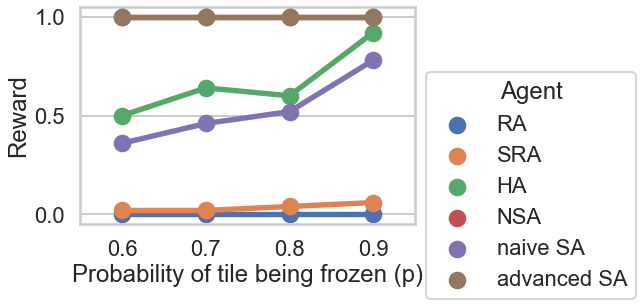

In [4]:
sns.set(rc = {'figure.figsize':(15,8)}, style='whitegrid')
sns.set_context("poster", rc={"lines.linewidth": 3}, font_scale=1)
# filename_a = '../../data/exp-A-15092022-231653.csv'
# rewards_a = pd.read_csv(filename_a)
rewards_a = pd.DataFrame(rewards_a, columns=('run', 'p', 'reward', 'agent'))
rewards_a['success'] = rewards_a['reward'].transform(lambda x: 1 if x>0.5 else 0)
rewards_a_plot = sns.pointplot(x='p', y="success", hue='agent', data=rewards_a, capsize=.2, ci=None)
rewards_a_plot.set_xlabel("Probability of tile being frozen (p)")
rewards_a_plot.set_ylabel("Reward")
plt.legend(loc="upper left", bbox_to_anchor=(1,0.75), title = "Agent")
# rewards_a_plot.set(ylim=(-0.1, 1.1))


In [5]:

a = rewards_a.groupby(['p', 'agent']).mean()
# rewards_a[rewards_a.agent.eq('non-symbolic')][rewards_a.success.eq(0)]a
a

run  reward  success
p   agent                             
0.6 HA           25.5  0.5000     0.50
    NSA          25.5  1.0000     1.00
    RA           25.5 -0.9800     0.00
    SRA          25.5  0.0200     0.02
    advanced SA  25.5  1.0000     1.00
    naive SA     25.5  0.3626     0.36
0.7 HA           25.5  0.6400     0.64
    NSA          25.5  1.0000     1.00
    RA           25.5 -0.9800     0.00
    SRA          25.5  0.0200     0.02
    advanced SA  25.5  1.0000     1.00
    naive SA     25.5  0.4600     0.46
0.8 HA           25.5  0.6000     0.60
    NSA          25.5  1.0000     1.00
    RA           25.5 -0.9400     0.00
    SRA          25.5  0.0400     0.04
    advanced SA  25.5  1.0000     1.00
    naive SA     25.5  0.5200     0.52
0.9 HA           25.5  0.9200     0.92
    NSA          25.5  1.0000     1.00
    RA           25.5 -0.8400     0.00
    SRA          25.5  0.0600     0.06
    advanced SA  25.5  1.0000     1.00
    naive SA     25.5  0.7800     0.78